In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, precision_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D


In [2]:
# Dataset
file_path = "Downloads/Dataset (1).xlsx"
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name='Sheet1')
df.head()

,Post ID,Post description,Date,Language,Translated Post Description,Sentiment,Hate,Stress or Anxiety
0,CgXDOaQDvGm,“I have decided that the global #monkeypox out...,07/23/2022,English,“I have decided that the global #monkeypox out...,neutral,Not Hate,Stress/Anxiety Detected
1,CgXaQpFOAqL,"If you can’t make fun of yourself, how the hel...",07/23/2022,English,"If you can’t make fun of yourself, how the hel...",anger,Hate,No Stress/Anxiety Detected
2,CgXpRmMIdzG,In light of the evolving monkeypox outbreak wi...,07/23/2022,English,In light of the evolving monkeypox outbreak wi...,neutral,Not Hate,Stress/Anxiety Detected
3,CgXMyIjP34S,#LinkInBio | The World Health Organization sai...,07/23/2022,English,#LinkInBio | The World Health Organization sai...,fear,Not Hate,Stress/Anxiety Detected
4,CgXaFGDsevq,If you've been hearing about monkeypox and wan...,07/23/2022,English,If you've been hearing about monkeypox and wan...,neutral,Not Hate,No Stress/Anxiety Detected


In [3]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower().strip()
df['Cleaned_Text'] = df['Translated Post Description'].astype(str).apply(clean_text)
df['Hate_Label'] = df['Hate'].apply(lambda x: 1 if x == 'Hate' else 0)
df.head()

,Post ID,Post description,Date,Language,Translated Post Description,Sentiment,Hate,Stress or Anxiety,Cleaned_Text,Hate_Label
0,CgXDOaQDvGm,“I have decided that the global #monkeypox out...,07/23/2022,English,“I have decided that the global #monkeypox out...,neutral,Not Hate,Stress/Anxiety Detected,i have decided that the global monkeypox outbr...,0
1,CgXaQpFOAqL,"If you can’t make fun of yourself, how the hel...",07/23/2022,English,"If you can’t make fun of yourself, how the hel...",anger,Hate,No Stress/Anxiety Detected,if you cant make fun of yourself how the hell ...,1
2,CgXpRmMIdzG,In light of the evolving monkeypox outbreak wi...,07/23/2022,English,In light of the evolving monkeypox outbreak wi...,neutral,Not Hate,Stress/Anxiety Detected,in light of the evolving monkeypox outbreak wi...,0
3,CgXMyIjP34S,#LinkInBio | The World Health Organization sai...,07/23/2022,English,#LinkInBio | The World Health Organization sai...,fear,Not Hate,Stress/Anxiety Detected,linkinbio the world health organization said ...,0
4,CgXaFGDsevq,If you've been hearing about monkeypox and wan...,07/23/2022,English,If you've been hearing about monkeypox and wan...,neutral,Not Hate,No Stress/Anxiety Detected,if youve been hearing about monkeypox and want...,0


In [5]:
print("Missing Values Count:\n", df.isnull().sum())

Missing Values Count:
 Post ID                        0
Post description               0
Date                           0
Language                       0
Translated Post Description    0
Sentiment                      0
Hate                           0
Stress or Anxiety              0
Cleaned_Text                   0
Hate_Label                     0
dtype: int64


/var/folders/8v/j8pkmx0n4td2qyyslsvztkgh0000gn/T/ipykernel_38028/454677205.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hate', data=df, palette='coolwarm')


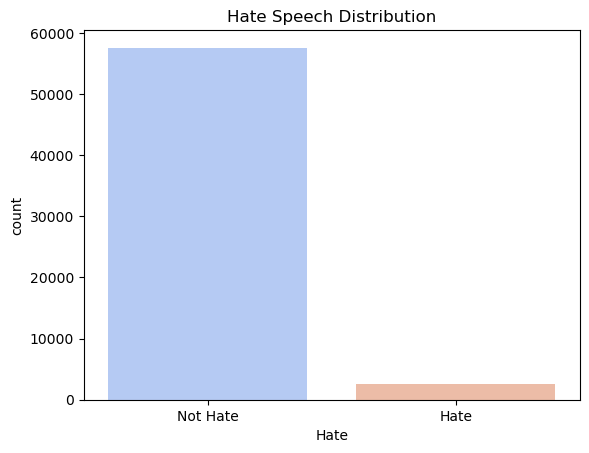

In [9]:
sns.countplot(x='Hate', data=df, palette='coolwarm')
plt.title('Hate Speech Distribution')
plt.show()

In [11]:
#TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Cleaned_Text'])
y = df['Hate_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((48101, 1000), (12026, 1000))

In [13]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [15]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     11601
           1       0.89      0.95      0.92     11427

    accuracy                           0.92     23028
   macro avg       0.92      0.92      0.92     23028
weighted avg       0.92      0.92      0.92     23028



In [17]:
# Random Forest 
f_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11601
           1       0.97      1.00      0.98     11427

    accuracy                           0.98     23028
   macro avg       0.98      0.98      0.98     23028
weighted avg       0.98      0.98      0.98     23028



In [18]:
from sklearn.svm import SVC
# svm
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92     11601
           1       0.89      0.96      0.93     11427

    accuracy                           0.92     23028
   macro avg       0.93      0.92      0.92     23028
weighted avg       0.93      0.92      0.92     23028



In [19]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Cleaned_Text'])
X_seq = tokenizer.texts_to_sequences(df['Cleaned_Text'])
X_pad = pad_sequences(X_seq, maxlen=100)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [21]:
# LSTM 
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128), 
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')  
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 118s 77ms/step - accuracy: 0.9597 - loss: 0.1501 - val_accuracy: 0.9710 - val_loss: 0.0886
Epoch 2/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 117s 78ms/step - accuracy: 0.9713 - loss: 0.0806 - val_accuracy: 0.9736 - val_loss: 0.0775
Epoch 3/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 117s 78ms/step - accuracy: 0.9791 - loss: 0.0601 - val_accuracy: 0.9765 - val_loss: 0.0723
Epoch 4/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 116s 77ms/step - accuracy: 0.9841 - loss: 0.0451 - val_accuracy: 0.9769 - val_loss: 0.0785
Epoch 5/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 0.9878 - loss: 0.0356 - val_accuracy: 0.9776 - val_loss: 0.0818



 Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     11601
           1       0.89      0.95      0.92     11427

    accuracy                           0.92     23028
   macro avg       0.92      0.92      0.92     23028
weighted avg       0.92      0.92      0.92     23028

Accuracy: 0.9215 | AUC/ROC: 0.9754 | Precision: 0.9234 | MAE: 0.0785 | MSE: 0.0785 | RMSE: 0.2802 | MAPE: 55801632797.1296%


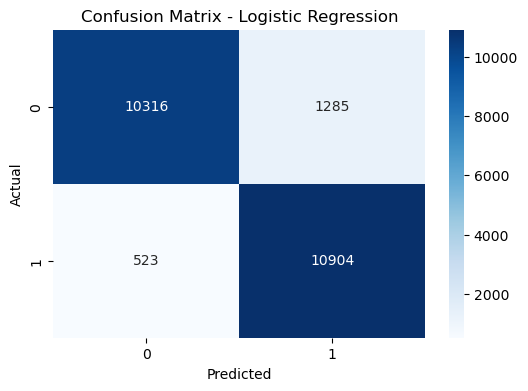


 Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11601
           1       0.97      1.00      0.98     11427

    accuracy                           0.98     23028
   macro avg       0.98      0.98      0.98     23028
weighted avg       0.98      0.98      0.98     23028

Accuracy: 0.9832 | AUC/ROC: 0.9986 | Precision: 0.9834 | MAE: 0.0168 | MSE: 0.0168 | RMSE: 0.1298 | MAPE: 14547507382.5473%


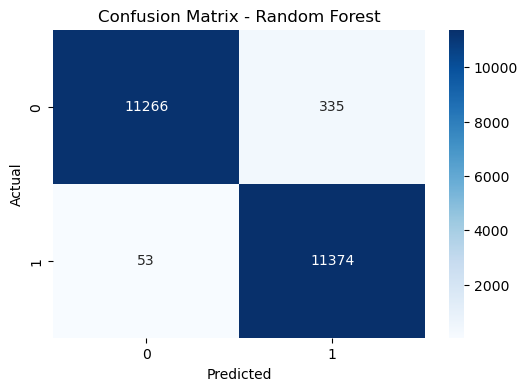


 Model: SVM
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     11601
           1       0.89      0.96      0.93     11427

    accuracy                           0.92     23028
   macro avg       0.93      0.92      0.92     23028
weighted avg       0.93      0.92      0.92     23028

Accuracy: 0.9234 | AUC/ROC: 0.9236 | Precision: 0.9260 | MAE: 0.0766 | MSE: 0.0766 | RMSE: 0.2768 | MAPE: 57842626369.7803%


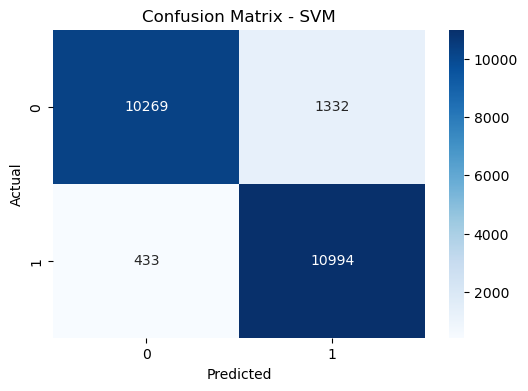

376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step

 Model: LSTM
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11526
           1       0.80      0.62      0.70       500

    accuracy                           0.98     12026
   macro avg       0.89      0.81      0.84     12026
weighted avg       0.98      0.98      0.98     12026

Accuracy: 0.9776 | AUC/ROC: 0.8066 | Precision: 0.9759 | MAE: 0.0224 | MSE: 0.0224 | RMSE: 0.1496 | MAPE: 6569100284.3007%


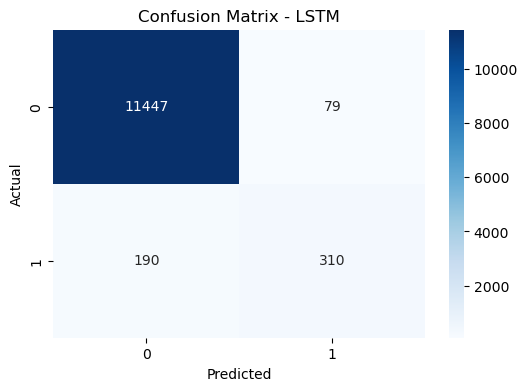

,AUC/ROC,Precision,Accuracy,MAE,MSE,RMSE,MAPE
Logistic Regression,0.975440,0.923379,0.921487,0.078513,0.078513,0.280202,5.580163e+10
Random Forest,0.998552,0.983444,0.983151,0.016849,0.016849,0.129804,1.454751e+10
SVM,0.923645,0.925993,0.923354,0.076646,0.076646,0.276850,5.784263e+10
LSTM,0.806573,0.975908,0.977632,0.022368,0.022368,0.149560,6.569100e+09



 Best Model Based on AUC/ROC: Random Forest (0.9986)
 Best Model Based on Lowest RMSE: Random Forest (0.1298)

 Recomm Best Model for Hate Speech Detection: Random Forest 


In [27]:
model_performance = {}
def evaluate_model(model, X_test, y_test, model_name, is_lstm=False):
    "Model evaluation and key performance metrics."
    try:
        if is_lstm:
            y_pred_prob = model.predict(X_test).flatten()
            y_pred = (y_pred_prob > 0.5).astype(int)
        else:
            y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
            y_pred = (y_pred_prob > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_prob) if not is_lstm else roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100 
        model_performance[model_name] = {
            "AUC/ROC": auc_roc, "Precision": precision, "Accuracy": accuracy,
            "MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape
        }
        print(f"\n Model: {model_name}")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy:.4f} | AUC/ROC: {auc_roc:.4f} | Precision: {precision:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.4f}%")
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    except Exception as e:
        print(f" Error Evaluating {model_name}: {e}")
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "SVM": svm_model
}
for name, model in models.items():
    evaluate_model(model, X_test, y_test, name)
evaluate_model(lstm_model, X_test_lstm, y_test_lstm, "LSTM", is_lstm=True)
evaluation_df = pd.DataFrame(model_performance).T  
from IPython.display import display
display(evaluation_df)
best_model_auc = max(evaluation_df.index, key=lambda x: evaluation_df.loc[x, "AUC/ROC"])
best_model_rmse = min(evaluation_df.index, key=lambda x: evaluation_df.loc[x, "RMSE"])
print(f"\n Best Model Based on AUC/ROC: {best_model_auc} ({evaluation_df.loc[best_model_auc, 'AUC/ROC']:.4f})")
print(f" Best Model Based on Lowest RMSE: {best_model_rmse} ({evaluation_df.loc[best_model_rmse, 'RMSE']:.4f})")
final_best_model = best_model_auc if best_model_auc == best_model_rmse else best_model_auc
print(f"\n Recomm Best Model for Hate Speech Detection: {final_best_model} ")